In [1]:
import wandb
from wandb.keras import WandbCallback
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Masking, Bidirectional
from keras.callbacks import EarlyStopping
from keras import utils
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

<h1>You can change the DataSets for Training & Testing but keep the same references for each</h1


In [2]:
trainX = pd.read_csv('./Train/trainX1.csv')
trainY = pd.read_csv('./Train/trainY1.csv')
testX = pd.read_csv('./Test/testX1.csv')
testY = pd.read_csv('./Test/testY1.csv')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ashoka (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.10 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade




Testing model with dropout = 0.100000

Epoch 1/2000
1/1 [==============================] - 9s 9s/step - loss: 0.7179 - accuracy: 0.5063 - auc: 0.5298 - val_loss: 0.6538 - val_accuracy: 0.6667 - val_auc: 0.2778
Epoch 2/2000
1/1 [==============================] - 0s 116ms/step - loss: 0.6972 - accuracy: 0.5190 - auc: 0.6058 - val_loss: 0.6616 - val_accuracy: 0.6667 - val_auc: 0.3889
Epoch 3/2000
1/1 [==============================] - 0s 98ms/step - loss: 0.7111 - accuracy: 0.4937 - auc: 0.4423 - val_loss: 0.6718 - val_accuracy: 0.6667 - val_auc: 0.5556
Epoch 4/2000
1/1 [==============================] - 0s 90ms/step - loss: 0.7060 - accuracy: 0.3924 - auc: 0.4196 - val_loss: 0.6836 - val_accuracy: 0.6667 - val_auc: 0.6111
Epoch 5/2000
1/1 [==============================] - 0s 85ms/step - loss: 0.7010 - accuracy: 0.4430 - auc: 0.4494 - val_loss: 0.6961 - val_accuracy: 0.5556 - val_auc: 0.6111
Epoch 6/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.6852 - accuracy: 0.

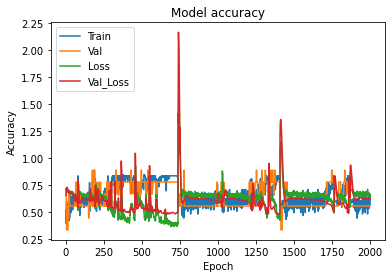

In [3]:
# Create model

def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()    
  

for dropout in [0.1]:
    wandb.init(reinit=True)
    print("\n\nTesting model with dropout = %f\n"%dropout)
    model = Sequential()
    model.add(Masking(mask_value=-10, input_shape=(541,1)))
    model.add(Bidirectional(LSTM(units=32)))
    model.add(Dropout(dropout))
    model.add(Dense(1, activation='sigmoid'))
    
    checkpoint_filepath = 'weights.{epoch:02d}-{accuracy:.2f}-{val_accuracy:.2f}.h5'
    
    model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='accuracy',
        mode='max',
        save_best_only=True)
    
    #early_stopper = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=False)
        
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy','AUC'])
    history = model.fit(trainX, trainY, epochs=2000, batch_size=81, validation_split=0.1, verbose=1, callbacks= [model_checkpoint_callback])
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val', 'Loss', 'Val_Loss'], loc='upper left')
    plt.show()
    wandb.save('model.h5')
    wandb.finish()

<h1>For best results, choose the weights returning the best accuracy on training and valiation</h1>

In [ ]:
model.load_weights(PLACE BEST WEIGHTS HERE)
# example : model.load_weights('./weights.377-0.85-0.78.h5')

In [2]:
import sklearn
from sklearn.metrics import roc_curve,roc_auc_score

prediction_prob = np.round(model.predict(testX),2)
validation = testY.values.tolist()
validation = np.array(validation)
validation = validation.flatten()
auc_score=roc_auc_score(validation,prediction_prob)
print("With a dropout of",dropout,"The AUC score is {:0.2f}".format(auc_score),"on test set")
#wandb.log({"ROC":plot_roc_curve(fpr,tpr)})   
fpr , tpr , thresholds = roc_curve (validation , prediction_prob)
plot_roc_curve(fpr,tpr)

NameError: name 'np' is not defined

In [6]:
comparison = {'prob': prediction_prob.flatten(), 'label': validation}
comparison = pd.DataFrame(comparison)
comp = comparison.sort_values(by='prob')
pd.set_option('display.max_columns', None)
comp.T

,1,31,27,7,10,13,29,25,17,26,19,18,14,37,9,5,6,33,36,12,21,28,16,35,30,0,23,8,32,11,34,4,22,15,20,2,24,3
prob,0.26,0.26,0.26,0.26,0.26,0.26,0.33,0.34,0.34,0.36,0.36,0.38,0.38,0.38,0.39,0.39,0.4,0.4,0.41,0.43,0.45,0.51,0.53,0.64,0.66,0.73,0.73,0.76,0.77,0.77,0.78,0.79,0.8,0.81,0.83,0.83,0.83,0.84
label,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.0,1.0,0.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.0,1.00,1.00,1.00,1.00,1.00


In [7]:
from sklearn.metrics import brier_score_loss

loss = brier_score_loss(comp['label'],comp['prob'])
prediction = list(map(lambda x: 0 if x<0.5 else 1, prediction_prob))

print("With a dropout of 0.1, The AUC score is {:0.2f}".format(auc_score),"on test set")
print("The accuracy on test set is {:0.2f}".format(sum([1 for i in range(len(prediction)) if prediction[i] == validation[i]])/len(prediction)*100))
print('The Brier Score on test set is {:0.2f}.' .format(loss))

With a dropout of 0.1, The AUC score is 0.87 on test set
The accuracy on test set is 81.58
The Brier Score on test set is 0.15.


array([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0])

In [1]:

# Prototype of implementation of B-LSTM model



def fibonacci_sequence(list):
    # If the result is above 10, log it with the message : 'Earthquake Risk is High, please evacuate immediately!'
    n = 2
    result = []
    fibonacci = [0, 1, 1, 2, 3, 5, 8, 13, 21,34,55,89,144,233,377,610,987,1597,2584,4181]
    for i in list:
        if i == 0:
            if n > 2:
                print(fibonacci[n-1])
                result.append(fibonacci[n-1])
                if fibonacci[n-1] > 10:
                    print("Earthquake Risk is High, please evacuate immediately!")
                n -= 1	
            else:
                n = 2
                print(fibonacci[n])
                result.append(fibonacci[n])
                if fibonacci[n] > 10:
                    print("Earthquake Risk is High, please evacuate immediately!")
        elif i == 1:
            print(fibonacci[n+1])
            result.append(fibonacci[n+1])
            if fibonacci[n+1] > 10:
                print("Earthquake Risk is High, please evacuate immediately!")
            n += 1
        else:
            print("Invalid input")

    plt.plot(result)
    plt.xticks(range(len(list)), list)
    plt.xlabel('Model Output')
    plt.ylabel('Fibonacci Sequence')
    plt.axhline(y=10, color='orange', linestyle='-')
    plt.axvline(x=len(list)-1, color='red', linestyle='-')
    plt.legend(['Estimated Risk', 'Alert Threshold','Earthquake' ])
    return result

list = comp['label']
fibonacci_sequence(list)



NameError: name 'comp' is not defined